* Please make a copy of this notebook and replace "LastName" and "FirstName" in the title with your own names. Also, write your name in the following text block.

* Then, fill in the file with your code and comments on the results.

* Finally, share your completed work with me by sending the link via email as your final submission, no later than **January 6th, 2025**.

* You can contact me if you have any questions. If necessary, we can meet either face-to-face or via online video calls to resolve them.

---

**Last Name:** José Luis


**First Name:** Martínez Martínez


---

# Problem 1: Prediction




In [ ]:
# Libraries that will be used in this part 1.


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from IPython.core.display import display, HTML # beautify prints
from tabulate import tabulate # beautify prints

from sklearn.model_selection import train_test_split # splitting DB

from sklearn.linear_model import LinearRegression # Linear Regression (OLS)

from sklearn.metrics import mean_absolute_error, root_mean_squared_error # Loss FunctionS

from sklearn.preprocessing import PolynomialFeatures, StandardScaler #Pre-processing
from sklearn.pipeline import Pipeline #Pre-Processing

from sklearn.linear_model import Lasso #LASSO model

from sklearn.linear_model import Ridge #Ridge model

from sklearn.model_selection import GridSearchCV    # C-V
from sklearn.model_selection import KFold           # k-fold CV
from sklearn.model_selection import cross_val_score # C-V
from sklearn.linear_model import LassoCV # CV in LASSO

from sklearn import tree #Randome tree

from sklearn.ensemble import RandomForestRegressor #Random Forest

from statsmodels.stats.outliers_influence import variance_inflation_factor #VIF
from statsmodels.tools.tools import add_constant #VIF

# !pip install seaborn # for graphs if needed


## DB elicitation

The first part consists of selecting a database, cleaning it (performing any pre-processing if convenient), and dividing our final sample into training and test data.

In [ ]:
# import db
censu = pd.read_csv('calif_penn_2011_2.csv')

In [ ]:
# Generating table of DB features

  # Read the descriptions from the file
with open('calif_penn_2011.txt', 'r') as file:
    lines = file.readlines()

  # Process the descriptions to extract column names and their explanations
descriptions = []
for line in lines:
    if '"' in line:  # Filter only lines with relevant information
        column, desc = line.split('"')[1], line.split('"')[2].strip()
        descriptions.append((column, desc))

  # Create a DataFrame with column names and data types from censu.info()
censu_info = pd.DataFrame({
    'Column': censu.columns,
    'Dtype': [str(censu[col].dtype) for col in censu.columns]  # Data types
})

  # Convert the descriptions into a DataFrame
descriptions_df = pd.DataFrame(descriptions, columns=['Column', 'Description'])

  # Merge both DataFrames on the column names
combined_info = pd.merge(censu_info, descriptions_df, on='Column', how='left')


  # Adding number of null values over total cells

null_counts = censu.isnull().sum()  # Total nulls per column
non_null_counts = censu.notnull().sum()  # Total non-nulls per column
null_proportions = (censu.isnull().mean() * 100).round(2)  # Percentage of nulls

  # Add these values to the combined_info DataFrame
combined_info['Non-Null'] = non_null_counts.values
combined_info['Null'] = null_counts.values
combined_info['Null Prop.(%)'] = null_proportions.values

  # Making print more beautifull
print(tabulate(combined_info, headers="keys", tablefmt="pretty",showindex=False))

+-----------------------------+---------+------------------------------------------------------------+----------+------+---------------+
|           Column            |  Dtype  |                        Description                         | Non-Null | Null | Null Prop.(%) |
+-----------------------------+---------+------------------------------------------------------------+----------+------+---------------+
|             X1              |  int64  |                     observation number                     |   8456   |  0   |      0.0      |
|           GEO.id2           |  int64  |                     geographic ID code                     |   8456   |  0   |      0.0      |
|           STATEFP           |  int64  |                     code for the state                     |   8456   |  0   |      0.0      |
|          COUNTYFP           |  int64  |                    code for the county                     |   8456   |  0   |      0.0      |
|           TRACTCE           |  int64  |

In [ ]:
# Columns to drop from DB

columns_to_drop1 = ['X1','GEO.id2','STATEFP','COUNTYFP','TRACTCE','GEO.display.label'] # Due to its lack of predicting power
columns_to_drop2 = ['Built_1939_or_earlier','Bedrooms_0','Renters','Mean_household_income'] # Due to high/perfect colinearity problems

columns_to_drop = columns_to_drop1 + columns_to_drop2

In [ ]:
# Final DB
fcensu = censu.drop(columns=columns_to_drop)
fcombined_info = combined_info[~combined_info['Column'].isin(columns_to_drop)].reset_index(drop=True)

print(tabulate(fcombined_info, headers="keys", tablefmt="pretty",showindex=False))

+-----------------------------+---------+------------------------------------------------------------+----------+------+---------------+
|           Column            |  Dtype  |                        Description                         | Non-Null | Null | Null Prop.(%) |
+-----------------------------+---------+------------------------------------------------------------+----------+------+---------------+
|         POPULATION          |  int64  |                  population of the tract                   |   8456   |  0   |      0.0      |
|          LATITUDE           | float64 |                   latitude of the tract                    |   8456   |  0   |      0.0      |
|          LONGITUDE          | float64 |                   longitude of the tract                   |   8456   |  0   |      0.0      |
|     Median_house_value      | float64 |       median value of the housing units in the tract       |   7974   | 482  |      5.7      |
|         Total_units         |  int64  |

In [ ]:
# Dealing with NUll data.

  # Dropping null data rows for Median house value (Dependent Variable)
fcensu.dropna(subset=['Median_house_value'],inplace=True)
  # Implacing median values for the rest of variables null values (Independent Variables)
fcensu.fillna(fcensu.median(), inplace=True)


In [ ]:
# Computting final impact on our original DB

original_size = censu.shape[0]
cleaned_size = fcensu.shape[0]

print(f"Original dataset size: {original_size}")
print(f"Cleaned dataset size: {cleaned_size}")
print(f"Percentage of data retained: {(cleaned_size / original_size) * 100:.2f}%")
print(f"Percentage of data lost: {((original_size - cleaned_size) / original_size) * 100:.2f}%")

Original dataset size: 8456
Cleaned dataset size: 7974
Percentage of data retained: 94.30%
Percentage of data lost: 5.70%


In [ ]:
# Finally split the DB into training and test sets

target = "Median_house_value" # Dependent variable
predictors = [                # Independent variables
    "POPULATION", "LATITUDE", "LONGITUDE", "Total_units", "Vacant_units",
    "Median_rooms", "Mean_household_size_owners", "Mean_household_size_renters",
    "Built_2005_or_later", "Built_2000_to_2004", "Built_1990s", "Built_1980s",
    "Built_1970s", "Built_1960s", "Built_1950s", "Built_1940s", "Bedrooms_1", "Bedrooms_2",
    "Bedrooms_3", "Bedrooms_4", "Bedrooms_5_or_more", "Owners",
    "Median_household_income"
    ]


y = fcensu[target]
X = fcensu[predictors]


# 80-20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 6379
Testing set size: 1595


### Coments on this part:

About variable elicitation:

* We believe variables related to inner encoding systems, such as IDs or other types of codes, have little power to predict how the target variable will perform, beyond the impact they have through the features they represent (e.g., location codes have an impact due to their representation of location, not their inherent meaning).

* Additionally, we drop variables that could lead to perfect or high collinearity. The most evident examples are percentage variables (if we don't remove one, they sum up to 100, so we can isolate one based on the rest). Similarly, we remove the mean household income because it is likely highly correlated with the median household income.

About null data management elicitation:

* First, we remove all rows where the target variable is null. This is because introducing values for the target variable might generate noise when training the model. While using the mean or median of the entire sample might not create significant noise (as we would essentially regress to the mean and gain the additional power of a larger sample; but this I'm not sure).

* For the remaining rows with null data, we decided to fill the missing values with the median of the column. Why use the median instead of the mean? Because the median is more robust to outliers, and housing data tends to have many of these.




## Parametric Approach

### OLS:

#### Up to degree 1

In [ ]:
lm = LinearRegression()      # creates a model object
lm.fit(X_train, y_train)     # estimates (trains) in training set
# Metrics
y_test_pred_OLS = lm.predict(X_test)

In [ ]:
# Showing Results

intercept = lm.intercept_.round(4)
coef = lm.coef_.round(4)

tabla_coeficients = pd.DataFrame({
    "Variables": [''] +["Intercept"] +[''] + predictors,
    "Coeficients":[''] + [intercept] + [''] + list(coef)
})

MAE_OLS = mean_absolute_error(y_test, y_test_pred_OLS)
RMSE_OLS = root_mean_squared_error(y_test, y_test_pred_OLS)

print(tabulate(tabla_coeficients, headers="keys", tablefmt="pretty",showindex=False))
print('\n Metrics:\n')
print(f'MAE= {MAE_OLS}') # MAE
print(f'RMSE= {RMSE_OLS}')  # RMSE

+-----------------------------+-------------+
|          Variables          | Coeficients |
+-----------------------------+-------------+
|                             |             |
|          Intercept          | 699517.6618 |
|                             |             |
|         POPULATION          |  -16.8926   |
|          LATITUDE           | -11798.8191 |
|          LONGITUDE          | -3525.4912  |
|         Total_units         |   62.5617   |
|        Vacant_units         |  -47.1553   |
|        Median_rooms         | -15358.0309 |
| Mean_household_size_owners  | -4113.6057  |
| Mean_household_size_renters | -22395.9225 |
|     Built_2005_or_later     | -3348.0944  |
|     Built_2000_to_2004      |  -2178.972  |
|         Built_1990s         | -1903.6487  |
|         Built_1980s         |  -1775.874  |
|         Built_1970s         | -1138.6028  |
|         Built_1960s         |  -119.8602  |
|         Built_1950s         |  -533.9052  |
|         Built_1940s         |  2

#### Up to degree 2 + All possible Interactions

In [ ]:
# Adding Polinomial of degree 2 and all possible interactions
# Number_of_coefficient now = 23 + 23 + 23C2 = 299

poly = PolynomialFeatures(2)
X_train2 = poly.fit_transform(X_train)[:,1:]# Errase first constant column 'degree 0'
X_train2_sin = poly.fit_transform(X_train)

# Fit model with Polinomial
lm2 = LinearRegression()
lm2.fit(X_train2, y_train)

# Metrics
X_test2 = poly.transform(X_test)[:, 1:]  # Transforming also test part
y_test_pred_OLS2 = lm2.predict(X_test2)

MAE_OLS2 = mean_absolute_error(y_test, y_test_pred_OLS2)
RMSE_OLS2 = root_mean_squared_error(y_test, y_test_pred_OLS2)

print('\n Metrics:\n')
print(f'MAE= {MAE_OLS2}') # MAE
print(f'RMSE= {RMSE_OLS2}')  # RMSE



 Metrics:

MAE= 66476.78973539105
RMSE= 89874.35090103387


In [ ]:
# Just in case you want to see the coefficients

# Showing Results

intercept2 = lm2.intercept_.round(4)
coef2 = lm2.coef_.round(4)

# New features names
feature_names = poly.get_feature_names_out(input_features=X_train.columns)

tabla_coeficients2 = pd.DataFrame({
    "Variables": ["Intercept"] + list(feature_names[1:]),
    "Coeficients": [intercept2] + list(coef2)
})

# Show table
#print(tabulate(tabla_coeficients2, headers="keys", tablefmt="pretty",showindex=False))

### LASSO:

#### Up to degree 1

In [ ]:
# Elecitation of optimal alpha hyperparameter

steps = [ ('scale', StandardScaler()),('poly', PolynomialFeatures(1)), ('LASSO', Lasso()) ]
pipe  = Pipeline(steps)

## Define a grid for the hyperparameter value
grid = dict()
grid['LASSO__alpha'] = np.arange(21, 23, 0.1) #First tryed with np.arange(1, 25, 1) and results were Config: {'LASSO__alpha': 22}
# define search object
cv=KFold(n_splits=10, shuffle = True, random_state=42)
search = GridSearchCV(pipe, grid, scoring='neg_root_mean_squared_error', cv=cv)
# perform the search
results = search.fit(X_train, y_train)



print(f'RMSE: {-results.best_score_}') #RMSE: 103645.66530087817
print(f'Config: {results.best_params_}') #Config: {'LASSO__alpha': 21.300000000000004}

RMSE: 103645.66530087817
Config: {'LASSO__alpha': 21.300000000000004}


In [ ]:
# Computing LASSO with optimal alpha:

## preprocessing
steps = [('scale', StandardScaler()),
         ('poly', PolynomialFeatures(1, include_bias=False)), # erase first constant column, due to Polynomial of '0 degree'
         ('lasso', Lasso(alpha=21))]
pipe  = Pipeline(steps)

## fitting
pipe.fit(X_train, y_train)

## Prediction in test sample
y_test_pred_L1 = pipe.predict(X_test)

In [ ]:
# Showing results

intercept = pipe[2].intercept_.round(4)
coef = pipe[2].coef_.round(4)

tabla_coeficients = pd.DataFrame({
    "Variables": [''] +["Intercept"] +[''] + predictors,
    "Coeficients":[''] + [intercept] + [''] + list(coef)
})

MAE_L1 = mean_absolute_error(y_test, y_test_pred_L1)
RMSE_L1 = root_mean_squared_error(y_test, y_test_pred_L1)

print(tabulate(tabla_coeficients, headers="keys", tablefmt="pretty",showindex=False))
print('\n Metrics:\n')
print(f'MAE= {MAE_L1}') # MAE
print(f'RMSE= {RMSE_L1}')  # RMSE

+-----------------------------+-------------+
|          Variables          | Coeficients |
+-----------------------------+-------------+
|                             |             |
|          Intercept          | 368989.246  |
|                             |             |
|         POPULATION          | -31907.6469 |
|          LATITUDE           | -32314.6086 |
|          LONGITUDE          | -59753.0776 |
|         Total_units         | 44246.4184  |
|        Vacant_units         | -10109.9712 |
|        Median_rooms         | -16720.8476 |
| Mean_household_size_owners  | -3176.1445  |
| Mean_household_size_renters | -19600.7288 |
|     Built_2005_or_later     | -24344.6045 |
|     Built_2000_to_2004      | -21343.5611 |
|         Built_1990s         | -21803.4225 |
|         Built_1980s         | -23823.3781 |
|         Built_1970s         | -15728.8959 |
|         Built_1960s         | -1296.7861  |
|         Built_1950s         | -7876.6694  |
|         Built_1940s         |  1

#### Up to degree 2 + All possible Interactions

In [ ]:
# Computing LASSO with optimal alpha:

## preprocessing
steps = [('scale', StandardScaler()),
         ('poly', PolynomialFeatures(2, include_bias=False)), # erase first constant column, due to Polynomial of '0 degree'
         ('lasso', LassoCV(max_iter=1000000))]
pipe  = Pipeline(steps)

## fitting
pipe.fit(X_train, y_train)

## Prediction in test sample
y_test_pred_L1_2 = pipe.predict(X_test)

MAE_L1_2 = mean_absolute_error(y_test, y_test_pred_L1_2)
RMSE_L1_2 = root_mean_squared_error(y_test, y_test_pred_L1_2)

print(f'MAE= {MAE_L1_2}') # MAE
print(f'RMSE= {RMSE_L1_2}')  # RMSE


# LASSO(alpha=1):
#MAE= 66468.27105009482
#RMSE= 89873.36346128727

# LASSO(alpha=5):
#MAE= 66448.19130901879
#RMSE= 89880.44072695242

# LASSO(alpha=21):
#MAE= 66406.17921725825
#RMSE= 89888.13273847917

# LASSO(alpha=100):
#MAE= 66275.1187364626
#RMSE= 89916.87936252191

MAE= 66313.07837699661
RMSE= 90112.76667136922


In [ ]:
# Showing coefficients canceled by LASSO

# Getting coef.
lasso_model = pipe.named_steps['lasso']
poly_features = pipe.named_steps['poly']

# Extracting Names of features
feature_names = poly_features.get_feature_names_out(X_train.columns)

# Generating df
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_model.coef_
})

# Filter by coef == 0
discarded_features = coefficients[coefficients['Coefficient'] == 0]
print("\nFeatures discarded by Lasso:")
print(tabulate(discarded_features, headers="keys", tablefmt="pretty",showindex=False))


Features discarded by Lasso:
+----------------------------------------+-------------+
|                Feature                 | Coefficient |
+----------------------------------------+-------------+
|        POPULATION Median_rooms         |    -0.0     |
| POPULATION Mean_household_size_owners  |    -0.0     |
|         POPULATION Bedrooms_4          |     0.0     |
|          LONGITUDE Bedrooms_3          |     0.0     |
|        Vacant_units Bedrooms_1         |     0.0     |
|        Vacant_units Bedrooms_3         |     0.0     |
| Mean_household_size_renters Bedrooms_4 |     0.0     |
|     Built_2005_or_later Bedrooms_4     |    -0.0     |
|           Built_1960s Owners           |     0.0     |
|     Bedrooms_2 Bedrooms_5_or_more      |    -0.0     |
|              Bedrooms_3^2              |    -0.0     |
|   Bedrooms_3 Median_household_income   |    -0.0     |
+----------------------------------------+-------------+


### Ridge:

In [ ]:
# Elecitation of optimal alpha hyperparameter

steps2 = [
    ('scale', StandardScaler()),  # Escalado de datos
    ('poly', PolynomialFeatures(2)),  # Características polinómicas de grado 2
    ('ridge', Ridge(max_iter=1000000))  # Ridge regression
]
pipe2 = Pipeline(steps2)

## Define a grid for the hyperparameter value
grid = dict()
grid['ridge__alpha'] = np.arange(0.1, 10, .1)
# define search object
cv=KFold(n_splits=10, shuffle = True, random_state=42)
search = GridSearchCV(pipe2, grid, scoring='neg_root_mean_squared_error', cv=cv)
# perform the search
results = search.fit(X_train, y_train)

print(f'RMSE: {-results.best_score_}')#RMSE: 87247.08723430948
print(f'Config: {results.best_params_}')#Config: {'ridge__alpha': 1.7000000000000002}

In [ ]:
# Computing Ridge with optimal alpha:

# Definir el pipeline con Ridge
steps2 = [
    ('scale', StandardScaler()),  # Escalado de datos
    ('poly', PolynomialFeatures(2)),  # Características polinómicas de grado 2
    ('ridge', Ridge(alpha=1.7))  # Ridge regression
]
pipe2 = Pipeline(steps2)

## fitting
pipe2.fit(X_train, y_train)

## Prediction in test sample
y_test_pred_L2 = pipe2.predict(X_test)

MAE_L2 = mean_absolute_error(y_test, y_test_pred_L2)
RMSE_L2 = root_mean_squared_error(y_test, y_test_pred_L2)

print(f'MAE= {MAE_L2}') # MAE
print(f'RMSE= {RMSE_L2}')  # RMSE

MAE= 66310.28150509817
RMSE= 89875.80477604036


### Final Comments:

First, it is important to mention that OLS coefficients are more interpretable than those of LASSO and Ridge, where standardization and penalties reduce the direct interpretability of independent variables in relation to the dependent variable. However, since our primary goal is to predict, this limitation does not significantly affect us. Therefore, we can rely solely on our loss functions: MAE and RMSE (the latter penalizes errors more than proportionally as predictions deviate further from the actual value, due to the squared term).

Another difference is that OLS is more naïve in the sense that it treats all variables as relevant and assigns a value to each of them. This does not happen in LASSO, where ,by design, some coefficients can be assigned a value of zero (Ridge also reduces the magnitude of coefficients, but not as sharply as LASSO (coefficient never = 0)); this is the way penalty regressions deals with overcomplexity in the models, and that's why introducing so many variables doesn't bring as many problems as in OLS.
Even so, in our case, using any of these models does not make a significant difference.

We might also have concerns about what alpha represents, whether there is a standard or "usual" range of values, and why sometimes changing it does not make a significant difference. However, it seems that this parameter is context-dependent and does not have further interpretability. Thus, we focus on computing it through cross-validation (the same applies to other hyperparameters).


#### DEALING WITH MULTICOLINEARITY:
* Is it really a problem for Penalizer Regressions?

From what I understand, all these penalty approaches are used to deal with overcomplexity in models and to combat overfitting, aiming for a more general and extrapolable model (in this sense, they are similar to the pruning process in decision trees). Therefore, they really don't have any direct implications for the 'usual' collinearity problem.

Even though I have read that excessive collinearity can generate some randomness in the selection of 'importance' among variables (meaning which variables are assigned a value of zero or close to zero), this is not a real problem here. We are only losing interpretability, but our main goal is to improve prediction. In this case, collinearity is not an issue (at least not in the classical econometric sense).


##### Evidence for Multicollinearity in our Data Base:
* Will be using VIF (Variance Inflation Factor):


$$VIF(X_i) = \frac{1}{1 - R^2_i}$$


* Where:

 $$R^2_i \text{ is the coefficient of determination obtained by regressing }X_i \text{ against all the other independent variables.}$$

* VIF = 1: No multicollinearity.
* 1 < VIF ≤ 5: Moderate multicollinearity.
* VIF > 5  High multicollinearity.



In [ ]:
# VIF for standar DB

# Adding constant
X_with_const = add_constant(X)

# Computing VIF for independent variables (X)
vif1_data = pd.DataFrame()
vif1_data["Variable"] = X_with_const.columns
vif1_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Selecting > 5 ones
vif1_c = vif1_data[vif1_data['VIF'] > 5].round(2)

print("\nVariables with VIF > 5:")
print(tabulate(vif1_c, headers="keys", tablefmt="pretty",showindex=False))


Variables with VIF > 5:
+--------------------+---------+
|      Variable      |   VIF   |
+--------------------+---------+
|       const        | 1392.73 |
|     POPULATION     |  8.09   |
|    Total_units     |  9.74   |
|    Median_rooms    |  12.93  |
|     Bedrooms_1     |  14.45  |
|     Bedrooms_2     |  13.47  |
|     Bedrooms_3     |  19.99  |
|     Bedrooms_4     |  20.24  |
| Bedrooms_5_or_more |  5.07   |
|       Owners       |  5.88   |
+--------------------+---------+


In [ ]:
# VIF for PolyFeature(2) transformed DB

# generate polinomyos discarding 'degree 0'
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly_with_const = add_constant(X_poly)

# Obtaining names
feature_names = poly.get_feature_names_out(X.columns)

column_names = ['Intercept'] + list(feature_names)
X_poly_df = pd.DataFrame(X_poly_with_const, columns=column_names)

# Computing VIF
vif2_data = pd.DataFrame()
vif2_data["feature"] = X_poly_df.columns
vif2_data["VIF"] = [variance_inflation_factor(X_poly_df.values, i) for i in range(X_poly_df.shape[1])]

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [ ]:
# Selecting > 5 ones
vif2_c = vif2_data[vif2_data['VIF'] > 5].round(2)
print(f"{vif2_c.shape[0]} out of {vif2_data.shape[0]} variables have VIF > 5")

298 out of 300 variables have VIF > 5


## No Parametric Approach



### Random Tree Model

In [ ]:
# Elecitation of optimal ccp hyperparameter (min_sample_leaf = 5)
# Recall this parameter is bounded as 0 =< ccp =< 1
treereg = tree.DecisionTreeRegressor(min_samples_leaf=5, random_state=42)
## Define a grid for the hyperparameter value
grid = dict()
grid['ccp_alpha'] = np.arange(0, 1, .1)
# define search object
cv=KFold(n_splits=10, shuffle = True, random_state=42)
search = GridSearchCV(treereg, grid, scoring='neg_root_mean_squared_error', cv=cv)
# perform the search
results = search.fit(X_train, y_train)

print(f'RMSE: {-results.best_score_}') #RMSE: 94405.14997194431
print(f'Config: {results.best_params_}') #Config: {'ccp_alpha': 0.0}

RMSE: 111234.55004998113
Config: {'ccp_alpha': 0.0}


In [ ]:
# Elecitation of optimal min_sample_leaf  hyperparameter (using before computed optimal ccp = 0.0)

treereg = tree.DecisionTreeRegressor(ccp_alpha=0, random_state=42)
## Define a grid for the hyperparameter value
grid = dict()
grid['min_samples_leaf'] = np.arange(1, 5, 1)
# define search object
cv=KFold(n_splits=10, shuffle = True, random_state=42)
search = GridSearchCV(treereg, grid, scoring='neg_root_mean_squared_error', cv=cv)
# perform the search
results = search.fit(X_train, y_train)

print(f'RMSE: {-results.best_score_}') # RMSE: 92166.38044868765
print(f'Config: {results.best_params_}') #Config: {'min_samples_leaf': 2}

RMSE: 92166.38044868765
Config: {'min_samples_leaf': 2}


In [ ]:
# Estimation using optimal hyperparameters

treereg = tree.DecisionTreeRegressor(ccp_alpha=0,min_samples_leaf=2, random_state=42)
treereg = treereg.fit(X_train, y_train)

## Metrics in testing sample
y_test_pred_RT = treereg.predict(X_test)

MAE_RT = mean_absolute_error(y_test, y_test_pred_RT)
RMSE_RT = root_mean_squared_error(y_test, y_test_pred_RT)

print(f'MAE= {MAE_RT}') # MAE
print(f'RMSE= {RMSE_RT}') #RMSE

MAE= 49305.4263322884
RMSE= 92888.99886576382


In [ ]:
# Measuring Number of Final nodes (overfitting problem)


total_nodes = treereg.tree_.node_count

# Identifying final nodes
terminal_nodes = sum(treereg.tree_.children_left == -1)  # children_left = -1 indica nodo terminal

print(f"Total nodes: {total_nodes}")
print(f"Total terminal nodes: {terminal_nodes}")

Total nodes: 5133
Total terminal nodes: 2567


In [ ]:
## Plot tree
import contextlib
import io

# Cancel annoying text primp
with contextlib.redirect_stdout(io.StringIO()):
    fig = plt.figure(figsize=(80, 80))
    tree.plot_tree(treereg, feature_names=predictors, filled=True)

# SAve imagen
plt.savefig("decision_tree.png", dpi=300, bbox_inches="tight")

# Show graph
plt.show()

# But it is so huge I think is pointless to print it (I will attach the image in the email)


In [ ]:
## Get importance

treereg = tree.DecisionTreeRegressor(ccp_alpha=0,min_samples_leaf=2, random_state=42)
treereg = treereg.fit(X_train, y_train)

importance1 = pd.Series(treereg.feature_importances_).sort_values(ascending=False)
importance1.index = [predictors[i] for i in importance1.index]

# Creating dictionary with values
importance1_dict = {predictor: importance1[predictor] for predictor in predictors}

# Treating the df
df_importance1 = pd.DataFrame(importance1_dict, index=['IMPORTANCE']).transpose()
df_importance1_sorted = df_importance1.sort_values(by='IMPORTANCE', ascending=False)

# Naming columns
df_importance1_sorted = df_importance1_sorted.reset_index()
df_importance1_sorted.columns = ['VARIABLE', 'IMPORTANCE']

df_importance1 = df_importance1.reset_index()
df_importance1.columns = ['VARIABLE', 'IMPORTANCE']

# Showing Table
print(tabulate(df_importance1_sorted.round(4), headers="keys", tablefmt="pretty", showindex=False))



+-----------------------------+------------+
|          VARIABLE           | IMPORTANCE |
+-----------------------------+------------+
|   Median_household_income   |   0.4524   |
|          LONGITUDE          |   0.1592   |
|          LATITUDE           |   0.0958   |
| Mean_household_size_renters |   0.0458   |
|         Bedrooms_1          |   0.0356   |
|         Bedrooms_3          |   0.021    |
|         Built_1940s         |   0.0201   |
|         Built_1960s         |   0.0165   |
|           Owners            |   0.0162   |
| Mean_household_size_owners  |   0.0162   |
|         Built_1970s         |   0.0125   |
|         Built_1950s         |   0.0124   |
|        Vacant_units         |   0.0123   |
|         Built_1980s         |   0.0118   |
|         Bedrooms_2          |   0.0095   |
|     Built_2000_to_2004      |   0.0093   |
|        Median_rooms         |   0.0089   |
|         Built_1990s         |   0.0086   |
|     Built_2005_or_later     |   0.0085   |
|     Bedr

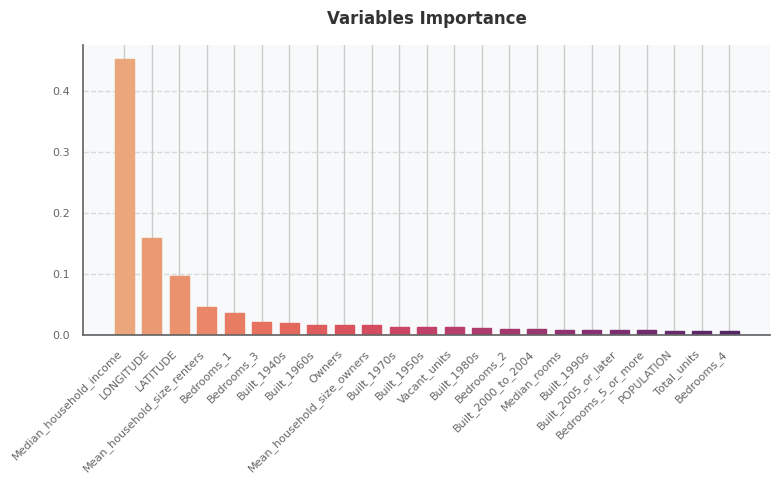

In [ ]:
# Plot Importance

# Conf. stiles
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

# Figure
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
ax.set_facecolor('#f8f9fa')

# Bar graph with gradient colors
bars = ax.bar(df_importance1_sorted['VARIABLE'],
              df_importance1_sorted['IMPORTANCE'],
              width=0.7)

colors = sns.color_palette("flare", n_colors=len(df_importance1_sorted))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')

# Add grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')
ax.set_axisbelow(True)

# Labels
plt.xticks(rotation=45, ha='right')
ax.tick_params(axis='both', which='major', labelsize=8, colors='#666666')  # Reduced from 10 to 8

plt.title("Variables Importance",
          fontsize=12,  # Reduced from 16 to 12
          pad=15,      # Reduced from 20 to 15
          fontweight='bold',
          fontfamily='sans-serif',
          color='#333333')


# Show graph
plt.tight_layout()
plt.show()

### Random Forest Model

In [ ]:
# Elecitation of optimal min_sample_leaf hyperparameter (n_estimators=100, max_features = 'sqrt')

RFreg = RandomForestRegressor(n_estimators=100,max_features = 'sqrt', random_state = 42)

## Define a grid for the hyperparameter value
grid = dict()
grid['min_samples_leaf'] = np.arange(1, 6, 1)
# define search object
cv=KFold(n_splits=10, shuffle = True, random_state=42)
search = GridSearchCV(RFreg, grid, scoring='neg_root_mean_squared_error', cv=cv)
# perform the search
results = search.fit(X_train, y_train)

print(f'RMSE: {-results.best_score_}') #RMSE: 68534.04137110502
print(f'Config: {results.best_params_}') #Config: {'min_samples_leaf': 1}

RMSE: 68534.04137110502
Config: {'min_samples_leaf': 1}


In [ ]:
# Elecitation of optimal max_features hyperparameter (n_estimators=100, min_samples_leaf = 1)

RFreg = RandomForestRegressor(n_estimators=100,min_samples_leaf = 1, random_state = 42)

## Define a grid for the hyperparameter value
grid = dict()
grid['max_features'] = [0.5,0.25,0.8] # already tryed with ['sqrt','log2',0.5,23] and result was also 0.5
# define search object
cv=KFold(n_splits=10, shuffle = True, random_state=42)
search = GridSearchCV(RFreg, grid, scoring='neg_root_mean_squared_error', cv=cv)
# perform the search
results = search.fit(X_train, y_train)

print(f'RMSE: {-results.best_score_}') #RMSE: 64987.73155469147
print(f'Config: {results.best_params_}') #Config: {'max_features': 0.5}

RMSE: 64987.73155469147
Config: {'max_features': 0.5}


In [ ]:
# Computing Random Forest with optimal hyperparameters

RFreg = RandomForestRegressor(n_estimators=100,min_samples_leaf=1,max_features =0.5,random_state = 42)
RFreg = RFreg.fit(X_train, y_train)

y_test_pred_RF = RFreg.predict(X_test)

MAE_RF = mean_absolute_error(y_test, y_test_pred_RF)
RMSE_RF = root_mean_squared_error(y_test, y_test_pred_RF)

print(f'MAE= {MAE_RF}') # MAE
print(f'RMSE= {RMSE_RF}') #RMSE

MAE= 41829.027586206896
RMSE= 71377.19741699957


In [ ]:
## Get importance

RFreg = RandomForestRegressor(n_estimators=100,min_samples_leaf=1,max_features =0.5,random_state = 42)
RFreg = RFreg.fit(X_train, y_train)

importance2 = pd.Series(RFreg.feature_importances_).sort_values(ascending=False)

importance2.index = [predictors[i] for i in importance2.index]

# Creating dictionary with values
importance2_dict = {predictor: importance2[predictor] for predictor in predictors}

# Treating the df
df_importance2 = pd.DataFrame(importance2_dict, index=['IMPORTANCE']).transpose()
df_importance2_sorted = df_importance2.sort_values(by='IMPORTANCE', ascending=False)

# Naming columns
df_importance2_sorted = df_importance2_sorted.reset_index()
df_importance2_sorted.columns = ['VARIABLE', 'IMPORTANCE']

df_importance2 = df_importance2.reset_index()
df_importance2.columns = ['VARIABLE', 'IMPORTANCE']

# Showing Table
print(tabulate(df_importance2_sorted.round(4), headers="keys", tablefmt="pretty", showindex=False))


+-----------------------------+------------+
|          VARIABLE           | IMPORTANCE |
+-----------------------------+------------+
|   Median_household_income   |   0.3639   |
|          LONGITUDE          |   0.166    |
|          LATITUDE           |   0.1072   |
| Mean_household_size_renters |   0.0452   |
|           Owners            |   0.029    |
|         Bedrooms_3          |   0.0287   |
| Mean_household_size_owners  |   0.0278   |
|         Bedrooms_1          |   0.0244   |
|        Median_rooms         |   0.0243   |
|     Bedrooms_5_or_more      |   0.0199   |
|         Built_1940s         |   0.0191   |
|         Built_1960s         |   0.0161   |
|         Built_1980s         |   0.016    |
|         Bedrooms_4          |   0.0159   |
|        Vacant_units         |   0.0122   |
|         Bedrooms_2          |   0.012    |
|         Built_1970s         |   0.0117   |
|         Built_1950s         |   0.0112   |
|     Built_2000_to_2004      |   0.0106   |
|     Buil

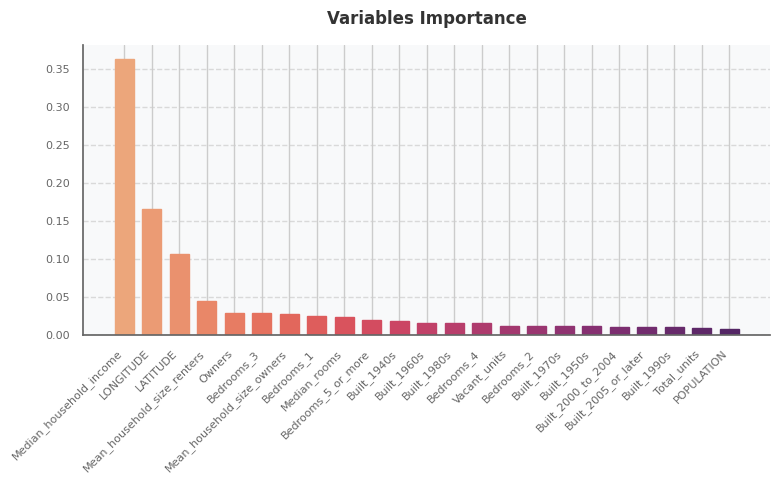

In [ ]:
# PLot Importance

# Stiles
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

# Fig and background
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
ax.set_facecolor('#f8f9fa')

# Bar graph with gradient colors
bars = ax.bar(df_importance2_sorted['VARIABLE'],
              df_importance2_sorted['IMPORTANCE'],
              width=0.7)

colors = sns.color_palette("flare", n_colors=len(df_importance1_sorted))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')

# Grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')
ax.set_axisbelow(True)

# Labels
plt.xticks(rotation=45, ha='right')
ax.tick_params(axis='both', which='major', labelsize=8, colors='#666666')  #

plt.title("Variables Importance",
          fontsize=12,
          pad=15,
          fontweight='bold',
          fontfamily='sans-serif',
          color='#333333')


# Show graph
plt.tight_layout()
plt.show()

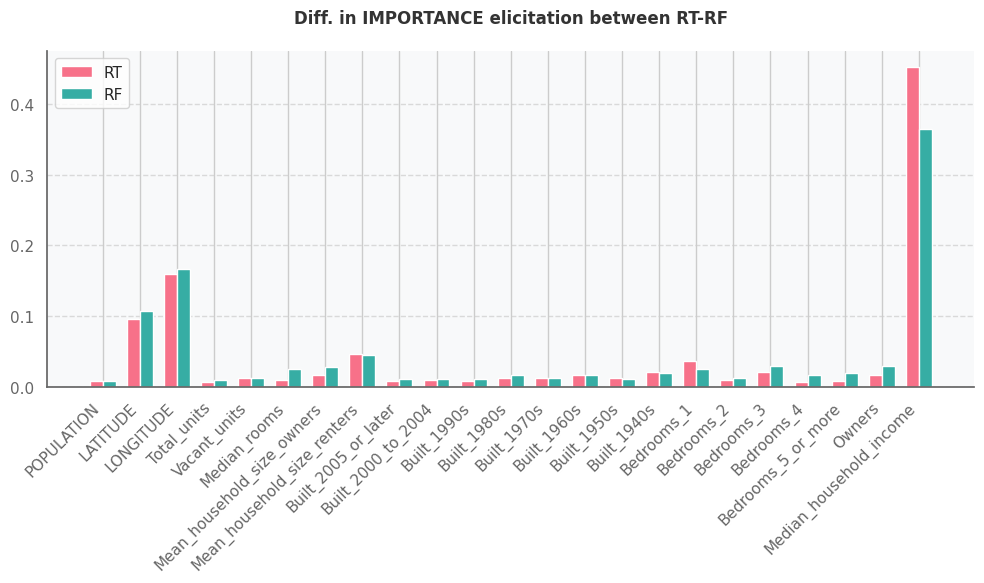

In [ ]:
# Plot differences between RT and RF Importance

# Stile
sns.set_theme(style="whitegrid")

# Fig.
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
ax.set_facecolor('#f8f9fa')

# Bar position
x = np.arange(len(df_importance1['VARIABLE']))
width = 0.35

# Generate bar
bars1 = ax.bar(x - width/2, df_importance1['IMPORTANCE'], width, label='RT',
               color=sns.color_palette("husl", 1))
bars2 = ax.bar(x + width/2, df_importance2['IMPORTANCE'], width, label='RF',
               color=sns.color_palette("husl", 2)[1])

# Axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')

# Grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')
ax.set_axisbelow(True)

# LAbels
ax.set_title('Diff. in IMPORTANCE elicitation between RT-RF', pad=20, fontweight='bold', color='#333333')
ax.set_xticks(x)
ax.set_xticklabels(df_importance1['VARIABLE'], rotation=45, ha='right')

# Text color
ax.tick_params(axis='both', colors='#666666')

# Legend
ax.legend()

# Show Graph
plt.tight_layout()
plt.show()

### Final Comments:


So, as we can see, both of our models demand high complexity ('deep trees' = few minimum samples within nodes and no pruning in the case of random trees). What does this mean?

As we mentioned before, these hyperparameters are designed to combat overfitting so that our results can generalize better (external validity).

Nevertheless, in our case, it seems that this high level of complexity is acceptable. I couldn't find any significant meaning for this, but as long as we computed these hyperparameters using cross-validation methods, I think it should be fine.

Also, concerning the last figure, it seems that directly comparing RT and RF classifier algorithms doesn't make much sense (primarily because RF is essentially a refinement of RT, but also due to their construction and the inherent lack of interpretability that surrounds any ML method ('black-box')). Therefore, we can use it as a visualization of differences, but it seems pointless to extract any deep insights from it.

The comments on the implications of multicollinearity for these types of algorithms are similar to the previous ones. However, it is worth noting that in this case, as interpretability has completely disappeared (these algorithms are simply making decisions about splitting based purely on minimizing some loss function (RSS)), the issue of multicollinearity seems even more irrelevant.

## Which model will you use?


In [ ]:

# Crear diccionarios con los valores
mae_values = {
    "Model": ["OLS", "OLS_2", "L1", "L1_2", "L2_2", "RT", "RF"],
    "MAE": [MAE_OLS, MAE_OLS2, MAE_L1, MAE_L1_2, MAE_L2, MAE_RT, MAE_RF],
}

rmse_values = {
    "Model": ["OLS", "OLS_2", "L1", "L1_2", "L2_2", "RT", "RF"],
    "RMSE": [RMSE_OLS, RMSE_OLS2, RMSE_L1, RMSE_L1_2, RMSE_L2, RMSE_RT, RMSE_RF],
}

# Convertir a DataFrames
df_mae = pd.DataFrame(mae_values)
df_rmse = pd.DataFrame(rmse_values)

# Ordenar las tablas por los valores
df_mae = df_mae.sort_values(by="MAE", ascending=True).reset_index(drop=True)
df_rmse = df_rmse.sort_values(by="RMSE", ascending=True).reset_index(drop=True)

# Mostrar las tablas
print("MAE Table:")
print(tabulate(df_mae.round(2), headers="keys", tablefmt="pretty", showindex=False))

print("\nRMSE Table:")
print(tabulate(df_rmse.round(2), headers="keys", tablefmt="pretty", showindex=False))


MAE Table:
+-------+----------+
| Model |   MAE    |
+-------+----------+
|  RF   | 41829.03 |
|  RT   | 49305.43 |
| L2_2  | 66310.28 |
| L1_2  | 66406.18 |
| OLS_2 | 66476.8  |
|  OLS  | 81680.32 |
|  L1   | 81688.95 |
+-------+----------+

RMSE Table:
+-------+-----------+
| Model |   RMSE    |
+-------+-----------+
|  RF   |  71377.2  |
| OLS_2 | 89874.36  |
| L2_2  |  89875.8  |
| L1_2  | 89888.13  |
|  RT   |  92889.0  |
|  OLS  | 108423.86 |
|  L1   | 108428.16 |
+-------+-----------+




The decision is all about selecting the best predictor, and based on our two ways of measuring prediction accuracy (RMSE and MAE), our selected model has to be the RF model.


---

# Problem 2: Financial Investment

* This problem is **optional**. Completing it will give you 1 extra point.

* We are interested in estimating the effect of participation in 401(k) pension plans on employees’ net financial assets. The dataset [pension.csv](https://raw.githubusercontent.com/albarran/00datos/refs/heads/main/pension.csv) contains information about net financial assets (*net_tfa*) and participation in a 401(k) plan (*p401*), along with several additional individual characteristics: age, income, education, family size, marital status, having two earners in the household, having a defined benefit (DB) pension (a type of retirement plan where an employer guarantees a specified retirement amount), participation in an IRA (Individual Retirement Account, a type of retirement savings account with tax advantages), and homeownership. You can find more information about the variables [here](https://search.r-project.org/CRAN/refmans/hdm/html/pension.html).

* Since saving preferences (which are unobservable) can directly affect net asset holdings and the decision to participate, and may also be correlated with observable characteristics (e.g., income), participation in 401(k) plans can be endogenous. However, it is possible to exploit randomness (conditional on confounding variables) in eligibility for 401(k) plans (*e401*). An instrumental variable (IV) approach could be used to estimate the causal effect, but in this case, we will focus on estimating the intention-to-treat effect.


* Load the data and check the variables types.

In [ ]:
# Libraries that will be used in this part 2.


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf # importing models

!pip install -U DoubleML # Double Lasso regression
from doubleml import DoubleMLData # Double Lasso regression
from doubleml import DoubleMLPLR # Double Lasso regression

from sklearn.linear_model import LassoCV # CV in LASSO

from sklearn.ensemble import RandomForestRegressor # Random Forest for Machine Labor#

from sklearn.base import clone # ?

from sklearn.pipeline import make_pipeline # Preprocessing
from sklearn.pipeline import Pipeline #Pre-Processing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler #Pre-processing

from tabulate import tabulate # beautify prints

In [ ]:
# URL de la base de datos
url = "https://raw.githubusercontent.com/albarran/00datos/refs/heads/main/pension.csv"
pension = pd.read_csv(url)

In [ ]:
  # Create a DataFrame with column names and data types from censu.info()
pension_info = pd.DataFrame({
    'Column': pension.columns,
    'Dtype': [str(pension[col].dtype) for col in pension.columns]  # Data types
})

# print(tabulate(pension_info, headers="keys", tablefmt="pretty",showindex=False))

+----------+---------+
|  Column  |  Dtype  |
+----------+---------+
|   ira    |  int64  |
|   a401   |  int64  |
|   hval   |  int64  |
|  hmort   |  int64  |
| hequity  |  int64  |
|   nifa   |  int64  |
| net_nifa |  int64  |
|   tfa    |  int64  |
| net_tfa  |  int64  |
|  tfa_he  |  int64  |
|    tw    |  int64  |
|   age    |  int64  |
|   inc    |  int64  |
|  fsize   |  int64  |
|   educ   |  int64  |
|    db    |  int64  |
|   marr   |  int64  |
|   male   |  int64  |
| twoearn  |  int64  |
|  dum91   |  int64  |
|   e401   |  int64  |
|   p401   |  int64  |
|   pira   |  int64  |
|   nohs   |  int64  |
|    hs    |  int64  |
|  smcol   |  int64  |
|   col    |  int64  |
|   icat   |  int64  |
|   ecat   |  int64  |
|   zhat   | float64 |
| net_n401 |  int64  |
|   hown   |  int64  |
|    i1    |  int64  |
|    i2    |  int64  |
|    i3    |  int64  |
|    i4    |  int64  |
|    i5    |  int64  |
|    i6    |  int64  |
|    i7    |  int64  |
|    a1    |  int64  |
|    a2    

In [ ]:
data = {
    "Variable": [
        "p401", "e401", "a401", "tw", "tfa", "net_tfa", "nifa", "net_nifa", "net_n401",
        "ira", "inc", "age", "fsize", "marr", "pira", "db", "hown", "educ", "male",
        "twoearn", "nohs", "hs", "smcol", "col", "hmort", "hequity", "hval"
    ],
    "Description": [
        "Participation in 401(k)", "Eligibility for 401(k)", "401(k) assets",
        "Total wealth (in US $)", "Financial assets (in US $)",
        "Net financial assets (in US $)", "Non-401k financial assets (in US $)",
        "Net non-401k financial assets", "Net non-401(k) assets (in US $)",
        "Individual retirement account (IRA)", "Income (in US $)", "Age",
        "Family size", "Married", "Participation in IRA", "Defined benefit pension",
        "Home owner", "Education (in years)", "Male", "Two earners",
        "Dummy for education: no high-school", "Dummy for education: high-school",
        "Dummy for education: some college", "Dummy for education: college",
        "Home mortgage (in US $)", "Home equity (in US $)", "Home value (in US $)"
    ]
}

df = pd.DataFrame(data)

print(tabulate(df, headers="keys", tablefmt="pretty",showindex=False))


+----------+-------------------------------------+
| Variable |             Description             |
+----------+-------------------------------------+
|   p401   |       Participation in 401(k)       |
|   e401   |       Eligibility for 401(k)        |
|   a401   |            401(k) assets            |
|    tw    |       Total wealth (in US $)        |
|   tfa    |     Financial assets (in US $)      |
| net_tfa  |   Net financial assets (in US $)    |
|   nifa   | Non-401k financial assets (in US $) |
| net_nifa |    Net non-401k financial assets    |
| net_n401 |   Net non-401(k) assets (in US $)   |
|   ira    | Individual retirement account (IRA) |
|   inc    |          Income (in US $)           |
|   age    |                 Age                 |
|  fsize   |             Family size             |
|   marr   |               Married               |
|   pira   |        Participation in IRA         |
|    db    |       Defined benefit pension       |
|   hown   |             Home o

## OLS

### Model elicitation:

$$\begin{equation}
\text{net_tfa} = \beta_0 + \beta_1 \text{e401} + \beta_2 \text{age} + \beta_3 \text{inc} + \beta_4 \text{fsize} + \beta_5 \text{marr} + \beta_6 \text{hown} + \beta_7 \text{ira} + \beta_8 \text{db} + \beta_9 \text{nohs} + \beta_{10} \text{hs} + \beta_{11} \text{smcol} + \epsilon
\end{equation}
$$

Where:


* net_tfa: Net financial assets

* e401: Elicitation for 401(k) plan
* age: Age of the individual
* male: gender
* inc: Income of the individual
* fsize: Family size
* Dummy variables:
  * marr: Marital status
  * hown: Homeownership status
  * ira: Participation in an IRA (other plans)
  * db: Defined benefit pension (other plans)
  * nohs: no high school diploma
  * hs: high school graduate
  * smcol: some college
  * col: college graduate (reference dummy)

Comments:

* We use categorical education to control for divergenses between levels instead of treating education as a continuos path (where we have to include upper degrees to control for no linear relationships)

* Also could be interesting to study some differences withing the effects of some variables on the 401k participation adding some interactions (but we will leave it like this)



In [ ]:
formula = 'net_tfa ~ e401 + age + male + inc + fsize + marr + hown + ira + db + nohs + hs + smcol'

#print(formula)

est = smf.ols(formula=formula, data=pension).fit()
print(est.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.095e+04   2904.059    -10.658      0.000   -3.66e+04   -2.53e+04
e401        6440.9114   1209.076      5.327      0.000    4070.875    8810.947
age          496.9634     58.145      8.547      0.000     382.988     610.939
male         272.0998   1467.283      0.185      0.853   -2604.073    3148.273
inc            0.7229      0.029     24.957      0.000       0.666       0.780
fsize       -435.6236    440.593     -0.989      0.323   -1299.275     428.028
marr       -1.143e+04   1529.463     -7.476      0.000   -1.44e+04   -8436.762
hown        1841.4929   1274.826      1.445      0.149    -657.425    4340.411
ira            2.2595      0.062     36.291      0.000       2.137       2.382
db         -6738.8787   1297.987     -5.192      0.000   -9283.197   -4194.561
nohs        1946.7605   2093.685      0.930      0.3


### Comments:

* It seems that the ITT effect of participation in the 401k plan is an increase of 6440.91 (Ceteris paribus) in mean of the net financial assets.

* There are no statistically significant differents between education-level groups so maybe is better idea to use education as a continuous variable instead.

* Also male, hown and fsize seems not to be statistically significant so we can considere to remove these (I will try to use the equity of the house rather than the property; as hown = 0 then hequity = 0)


Let's adjust our previous model as:



In [ ]:
formula2 = 'net_tfa ~ e401 + age + inc + marr + twoearn + hequity + ira + db + educ'

#print(formula2)

est = smf.ols(formula=formula2, data=pension).fit()
print(est.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.928e+04   3896.001     -4.948      0.000   -2.69e+04   -1.16e+04
e401        6764.4792   1191.634      5.677      0.000    4428.633    9100.325
age          288.6304     57.603      5.011      0.000     175.716     401.545
inc            0.7557      0.030     25.590      0.000       0.698       0.814
marr       -3403.1117   1518.785     -2.241      0.025   -6380.240    -425.984
twoearn    -1.667e+04   1511.071    -11.030      0.000   -1.96e+04   -1.37e+04
hequity        0.1035      0.012      8.638      0.000       0.080       0.127
ira            2.1551      0.062     34.657      0.000       2.033       2.277
db         -4019.0628   1299.228     -3.093      0.002   -6565.813   -1472.312
educ        -499.0902    215.150     -2.320      0.020    -920.828     -77.353


#### New Comments:

* Now educ is statistically significant for all normal values beyond 1%

* Now marr becoms stadistically no significant, maybe it is due to that before it was absorbing the effect of twoearn (wether both spouse percive income)

* hequity is statistically significant

Let's adjust the model, but I would like to intriduce cuadratic effects on educ:

In [ ]:
# Adding squared values
pension['educ_sq'] = pension['educ'] ** 2

#Computing model
formula3 = 'net_tfa ~ e401 + age + inc + twoearn + hequity + ira + db + educ + educ_sq '

#print(formula3)

est = smf.ols(formula=formula3, data=pension).fit()
print(est.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.405e+04   6349.946     -2.212      0.027   -2.65e+04   -1598.212
e401        6753.0202   1191.957      5.665      0.000    4416.542    9089.498
age          286.2146     57.596      4.969      0.000     173.315     399.114
inc            0.7376      0.029     25.122      0.000       0.680       0.795
twoearn    -1.844e+04   1244.918    -14.815      0.000   -2.09e+04    -1.6e+04
hequity        0.1015      0.012      8.501      0.000       0.078       0.125
ira            2.1490      0.062     34.550      0.000       2.027       2.271
db         -3439.0326   1265.298     -2.718      0.007   -5919.275    -958.790
educ       -1649.3971    908.522     -1.815      0.069   -3430.286     131.492
educ_sq       50.9355     36.507      1.395      0.163     -20.625     122.496


##### New new Comments:

* It looks like squared term of educ is not statistically significant. This is not like the usuall case when adding higher order terms results in lower dimension losing their significance; in this case is the higher one the one that has lose it, so even though we will not do a joint significance test we'll be not using the squared term and assume (base on this result) that education has in fact a linear effect.

Then our trully final regression will be:

## Model elicitation:

$$\begin{equation}
\text{net_tfa} = \beta_0 + \beta_1 \text{e401} + \beta_2 \text{age} + \beta_3 \text{inc} + \beta_4 \text{twoearn} +\beta_5 \text{hequity} + \beta_6 \text{ira} + \beta_7 \text{db} + \beta_8 \text{educ} + \epsilon
\end{equation}
$$

Where:


* net_tfa: Net financial assets


* e401: Elicitation for 401(k) plan
* age: Age of the individual
* inc: Income of the individual
* educ: education level (years)
* hequity: home equity
* Dummy variables:
  * twoearn: both spouse percive income  
  * ira: Participation in an IRA
  * db: Defined benefit pension
  


In [ ]:
#Computing model
formula4 = 'net_tfa ~ e401 + age + inc + twoearn + hequity + ira + db+ educ'

#print(formula3)

est = smf.ols(formula=formula4, data=pension).fit()
print(est.summary().tables[1])

# Extract coeficient
coef_e401_OLS = est.params['e401']

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.114e+04   3807.596     -5.551      0.000   -2.86e+04   -1.37e+04
e401        6711.4164   1191.641      5.632      0.000    4375.558    9047.275
age          284.4389     57.585      4.939      0.000     171.561     397.316
inc            0.7436      0.029     25.606      0.000       0.687       0.801
twoearn     -1.86e+04   1239.662    -15.007      0.000    -2.1e+04   -1.62e+04
hequity        0.1011      0.012      8.468      0.000       0.078       0.125
ira            2.1515      0.062     34.603      0.000       2.030       2.273
db         -3335.8256   1263.195     -2.641      0.008   -5811.944    -859.707
educ        -416.7989    212.035     -1.966      0.049    -832.431      -1.167


Then after some modifications our final result say that the ITT effect of participation in the 401k plan is an increase of 6711.4 (Ceteris paribus) in mean of the net financial assets.

## LASSO

In [ ]:
# Computing LASSO with optimal alpha:

X = pension[['e401', 'age', 'inc', 'twoearn', 'hequity', 'ira', 'db', 'educ']]
y = pension['net_tfa']

## preprocessing
steps = [('scale', StandardScaler()),
         ('poly', PolynomialFeatures(1, include_bias=False)), # erase first constant column, due to Polynomial of '0 degree'
         ('lasso', LassoCV(max_iter=100000))]
pipe  = Pipeline(steps)

## fitting
pipe.fit(X, y)

# Showing results

intercept = pipe[2].intercept_.round(4)
coef = pipe[2].coef_.round(4)

tabla_coeficients = pd.DataFrame({
    "Variables": [''] +["Intercept"] +[''] + ['e401', 'age', 'inc', 'twoearn' ,'hequity', 'ira', 'db', 'educ'],
    "Coeficients":[''] + [intercept] + [''] + list(coef)
})

print(tabulate(tabla_coeficients, headers="keys", tablefmt="pretty",showindex=False))


+-----------+-------------+
| Variables | Coeficients |
+-----------+-------------+
|           |             |
| Intercept | 18051.5348  |
|           |             |
|   e401    |  3208.1954  |
|    age    |  2932.582   |
|    inc    | 18367.0569  |
|  twoearn  | -8978.8043  |
|  hequity  |  5231.6873  |
|    ira    | 20742.7508  |
|    db     | -1447.0481  |
|   educ    | -1124.1308  |
+-----------+-------------+



### Comments:

Here we are using LASSO to compute this regression, but as long as I know this coefficients are less interpretable also non comparable to the ones of OLS do to the standarization.

So I don't think much can be say about this one or their coefficients' implication on causal effects.

## Double-Selection LASSO



In [ ]:
x_names = [ 'age', 'inc', 'twoearn', 'hequity', 'ira', 'db', 'educ']

# Generate object DoubleMLData
dml_pension = DoubleMLData(pension,
                          y_col='net_tfa',      # Dependent variable
                          d_cols='e401',        # Treatment varible
                          x_cols=x_names)       # Covariates

# Print to see features of the object
print(dml_pension)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['age', 'inc', 'twoearn', 'hequity', 'ira', 'db', 'educ']
Instrument variable(s): None
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 45 entries, ira to educ_sq
dtypes: float64(1), int64(44)
memory usage: 3.4 MB



In [ ]:
#First, just double selection LASSO

# learner = clone(LassoCV())
learner = clone(make_pipeline(StandardScaler(), LassoCV(max_iter=100000)))

y_model = learner
d_model = learner

np.random.seed(42)

obj_dml_pension = DoubleMLPLR(dml_pension, y_model, d_model)

obj_dml_pension.fit()

print(obj_dml_pension)

# ------------------ Fit summary       ------------------
#            coef      std err         t     P>|t|        2.5 %       97.5 %
# e401  6727.052705  1518.164187  4.431044  0.000009  3751.505577  9702.599833


# Extract coeficient
coef_e401_DSlasso = obj_dml_pension.coef[0]

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['age', 'inc', 'twoearn', 'hequity', 'ira', 'db', 'educ']
Instrument variable(s): None
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(max_iter=100000))])
Learner ml_m: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(max_iter=100000))])
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[53582.23289072]]
Learner ml_m RMSE: [[0.44963112]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
             coef      std err         t    

### Comments:

Okey now we introduce this Double-selection Lasso where (from what i have understand) we somehow exclude our treatment variable from the LASSO selection contest and fit a model (common OLS ; maybe this is why the result now seems to be interpretable/comparable, '6727.05' (not as in the mere LASSO case)) where only the survivors (the ones with relevance from Lasso point of view) of both variables regression, the dependent and the treatment one are  inlcuded.

* "__First step__: Regress $Y_i$ on ${X}_i$ and $D_i$ on ${X}_i$:"
* "__Second step__: Refit the model by OLS and include the $\mathbf{X}$'s that are significant predictors of $Y_i$ _and_ $D_i$."

~ From class notebook

Then if this is the case, why not to put all the variables and let the double-selection to elicitate the variables for us? (in contrast to what we have done in OLS case):


In [ ]:
# Using all aour variables

x_names_all = ['a401', 'tw', 'tfa', 'nifa', 'net_nifa',
    'net_n401', 'ira', 'inc', 'age', 'fsize', 'marr', 'pira', 'db',
    'hown', 'educ', 'male', 'twoearn', 'nohs', 'hs', 'smcol', 'col',
    'hmort', 'hequity', 'hval'
]



# Generate object DoubleMLData including all
dml_pension_all = DoubleMLData(pension,
                          y_col='net_tfa',      # Dependent variable
                          d_cols='e401',        # Treatment varible
                          x_cols=x_names_all)       # Covariates

#double selection LASSO


np.random.seed(42)
obj_dml_pension_all = DoubleMLPLR(dml_pension_all, y_model, d_model)

obj_dml_pension_all.fit()

#Show results
print(obj_dml_pension_all)

#------------------ Fit summary       ------------------
#           coef    std err         t     P>|t|       2.5 %     97.5 %
# e401 -38.302375  51.445393 -0.744525  0.456559 -139.133494  62.528743


# Extract coeficient
coef_e401_DSlasso_all = obj_dml_pension_all.coef[0]

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['a401', 'tw', 'tfa', 'nifa', 'net_nifa', 'net_n401', 'ira', 'inc', 'age', 'fsize', 'marr', 'pira', 'db', 'hown', 'educ', 'male', 'twoearn', 'nohs', 'hs', 'smcol', 'col', 'hmort', 'hequity', 'hval']
Instrument variable(s): None
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(max_iter=100000))])
Learner ml_m: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(max_iter=100000))])
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[2359.0179791]]
Learner ml_m RMSE: [[0.4204523]]

------------------ Resampling        ------------------
No. fo

#### New comments:

* Does this makes even sence?


* Okey, let's not put all of the variables, but being less picky than in the OLS case:
  * We take off anything 401k related
  * We choose all in 'net' state
  * We use education in continuous way

In [ ]:
# Using almost aour variables

x_names_lp = [ 'tw', 'net_nifa', 'ira', 'inc', 'age', 'fsize', 'marr', 'pira', 'db',
    'hown', 'educ', 'male', 'twoearn', 'hmort', 'hequity', 'hval'
]



# Generate object DoubleMLData less picky
dml_pension_lp = DoubleMLData(pension,
                          y_col='net_tfa',      # Dependent variable
                          d_cols='e401',        # Treatment varible
                          x_cols=x_names_lp)       # Covariates

#double selection LASSO


np.random.seed(42)
obj_dml_pension_lp = DoubleMLPLR(dml_pension_lp, y_model, d_model)

obj_dml_pension_lp.fit()

#Show results
print(obj_dml_pension_lp)

#------------------ Fit summary       ------------------
#             coef     std err          t          P>|t|        2.5 %  97.5 %
# e401  8624.063695  349.124096  24.702001  1.017830e-134  7939.793041  9308.33435

# Extract coeficient
coef_e401_DSlasso_lp = obj_dml_pension_lp.coef[0]


================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['tw', 'net_nifa', 'ira', 'inc', 'age', 'fsize', 'marr', 'pira', 'db', 'hown', 'educ', 'male', 'twoearn', 'hmort', 'hequity', 'hval']
Instrument variable(s): None
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(max_iter=100000))])
Learner ml_m: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(max_iter=100000))])
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[11909.98680971]]
Learner ml_m RMSE: [[0.44710693]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit s

##### New new comments:
* Now this looks more alike to what we have before.

* But, I have really no ground argument to stablish that this new model is better than the OLS or previous used Double-selection LASSO; so I can not  more than that now the effect of elicitation to 401k on net financial assests seems to be (Ceteris paribus) an increase of 8624.06, in mean.

## Double ML with RF

In [ ]:
# Now Double ML for a more flexible specification:

learner1 = clone(RandomForestRegressor())
# learner = clone(RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth= 5))

y_model1 = learner1
d_model1 = learner1


np.random.seed(42)

obj_dml_pension1 = DoubleMLPLR(dml_pension, y_model1, d_model1)

obj_dml_pension1.fit()

print(obj_dml_pension1)

#------------------ Fit summary       ------------------
#              coef     std err         t         P>|t|        2.5 %    97.5 %
# e401  10507.169724  1287.24343  8.162535  3.280651e-16  7984.218962   13030.120485

# Extract coeficient
coef_e401_ML = obj_dml_pension1.coef[0]



================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['age', 'inc', 'twoearn', 'hequity', 'ira', 'db', 'educ']
Instrument variable(s): None
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor()
Learner ml_m: RandomForestRegressor()
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[55607.04864299]]
Learner ml_m RMSE: [[0.46587556]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
              coef     std err         t         P>|t|        2.5 %  \
e401  10507.169724  1287.24343  8.162535  3.280651e-16  7984.218962   

            97.5 %  
e401  13030.120485  


### Comments:

In here what we are using is the same approach as before, but now our prediction dimension is not constrained by linearity and we can express relationships in a brouder manner (in our case this task will be performed by Random Forest).

  * Now Double ML for a more flexible specification:
\begin{aligned}
Y &=& \tau D+g(X) + \varepsilon \\
D &=& m(X) + v,
\end{aligned}

    * where $g(X)$ and $m(X)$ can be any general function (not only linear on $X$).

 ~ From class notebook

 But again I have no clue of which model is better in terms of approaching more accurately the causal effect of e401 on net_tfa.

 Anyway following same view as before i would like to introduce more variables and see what happen (in particular I'll use same varibales selection as in the 'less-picky' model) which my intuition says is the one that really exploit the double lasso selection:

In [ ]:
# Now Double ML for a more flexible specification:

np.random.seed(42)

obj_dml_pension1_lp = DoubleMLPLR(dml_pension_lp, y_model1, d_model1)

obj_dml_pension1_lp.fit()

print(obj_dml_pension1_lp)

#------------------ Fit summary       ------------------
#              coef     std err         t         P>|t|        2.5 %    97.5 %
# e401  7887.459235  296.23971  26.62526  3.462488e-156  7306.840073    8468.078397

# Extract coeficient
coef_e401_ML_lp = obj_dml_pension1_lp.coef[0]

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['tw', 'net_nifa', 'ira', 'inc', 'age', 'fsize', 'marr', 'pira', 'db', 'hown', 'educ', 'male', 'twoearn', 'hmort', 'hequity', 'hval']
Instrument variable(s): None
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor()
Learner ml_m: RandomForestRegressor()
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[12886.30779525]]
Learner ml_m RMSE: [[0.44851789]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
             coef    std err         t          P>|t|        2.5 %  \
e401  7887.459235  296.23971  26.62526  3.462488e-156  7306.840073   


### Summary Table:



In [ ]:
sum_t = {'OLS' : coef_e401_OLS, 'Double-Selection LASSO': coef_e401_DSlasso,
         'Double-Selectio LASSO (aug.)': coef_e401_DSlasso_lp, 'Double ML': coef_e401_ML, 'Double ML (aug.)': coef_e401_ML_lp}


df_sum = pd.DataFrame(sum_t,index=['e401']).transpose()

print(tabulate(df_sum.round(2), headers="keys", tablefmt="pretty",showindex=True))

+------------------------------+----------+
|                              |   e401   |
+------------------------------+----------+
|             OLS              | 6711.42  |
|    Double-Selection LASSO    |  -38.23  |
| Double-Selectio LASSO (aug.) | 8624.06  |
|          Double ML           | 10507.17 |
|       Double ML (aug.)       | 7887.46  |
+------------------------------+----------+
